## Compare performance of different methods on influenza dataset

Mamie Wang 03/13/2020

In [1]:
import sys, os

In [2]:
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'spectraltree'))

In [3]:
import numpy as np
import utils
import generation
import reconstruct_tree
import dendropy
import scipy
import time
from itertools import product
import matplotlib.pyplot as plt

from dendropy.model.discrete import simulate_discrete_chars, Jc69, Hky85
from dendropy.calculate.treecompare import symmetric_difference

## Load the tree and sequence file

The tree was constructed on 565 H3N2 virus hemagglutinin sequences (aligned sequence length = 1737 bp) using BEAST. 

In [4]:
tree_path = os.path.join(os.path.dirname(sys.path[0]), "data/NY_H3N2.newick")
fasta_path = os.path.join(os.path.dirname(sys.path[0]), "data/NY_H3N2.fasta")

In [5]:
H3N2_tree = dendropy.Tree.get(path=tree_path, schema="newick")
H3N2_dna = dendropy.DnaCharacterMatrix.get(file=open(fasta_path, "r"), schema="fasta")

In [6]:
len(H3N2_dna.taxon_namespace) # number of taxon

565

In [7]:
len(H3N2_dna[0]) # sequence length

1737

## Simulate sequences from the tree

We simulate the 565 sequences of length 1000 using the HKY85 model with transition/transversion ratio = 2, and mutation rate of 0.1

In [8]:
N = 1000 
data_HKY = simulate_discrete_chars(N, H3N2_tree, Hky85(kappa = 2), mutation_rate=0.1)
ch_list = list()
for t in data_HKY.taxon_namespace:
    ch_list.append([x.symbol for x in data_HKY[t]])
ch_arr = np.array(ch_list)
identical = np.array([np.mean(a == b) for a, b in product(ch_arr, repeat = 2)])

Here is the histogram of proportion of bases that are identical between pairs of sequences:

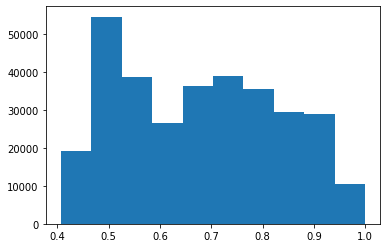

In [9]:
_ = plt.hist(identical)

### RaXML

In [12]:
raxml_HKY = reconstruct_tree.RAxML()

start_time = time.time()
raxml_HKY_tree = raxml_HKY(data_HKY, raxml_args="-T 2 --HKY85 -c 1")
raxml_time = time.time() - start_time
print("--- %s seconds ---" % raxml_time)

RaxML_RF, RaxML_F1 = reconstruct_tree.compare_trees(raxml_HKY_tree, H3N2_tree)
print("")
print("HKY: ")
print("RF = ", RaxML_RF)
print("F1% = ", RaxML_F1)
print("")

--- 429.76267409324646 seconds ---

HKY: 
RF =  104
F1% =  95.39007092198582



## HKY similarity

In [13]:
## compute the similarity matrix under HKY model
def HKY_similarity_matrix(observations, classes=None, verbose = False):
    m, N = observations.shape
    if classes is None:
        classes = np.unique(observations)
    k = len(classes)
    # From Tamura, K., and M. Nei. 1993
    # for each pair of sequences, 
    # 1. estimate the average base frequency for pairs of sequences
    # 2. compute purine transition proportion P1 (A <-> G)
    # 3. compute pyrimidine transition proportion P2 (T <-> C)
    # 3. compute transversion proportion Q (A <-> C, A <-> T, G <-> C, G <-> T)

    if verbose: print("Computing the average base frequency for each pair of sequences...")
    g = {}
    for x in classes:
        obs_x = observations == x
        g[x] = np.array([np.mean(np.hstack([a, b])) for a, b in product(obs_x, repeat = 2)]).reshape((m, m))
    
    g["R"] = g["A"] + g["G"]
    g["Y"] = g["T"] + g["C"]
    
    # compute transition and transversion proportion
    if verbose: print("Computing transition and transversion proportion for each pair of sequences...")
    P = {}
    for i, x in enumerate(classes):
        other_classes = np.delete(classes, i)
        for y in other_classes:
            P_x_y = np.array([np.mean(np.logical_and(a == x, b == y)) for a, b in product(observations, repeat = 2)]).reshape((m, m))
            P[x + y] = P_x_y
            
    P_1 = P['AG'] + P["GA"]
    P_2 = P['CT'] + P['TC']
    Q = P['AC'] + P['CA'] + P['AT'] + P['TA'] +\
        P['GC'] + P['CG'] + P['GT'] + P['TG']

    # compute the similarity (formula 7)
    if verbose: print("Computing similarity matrix")
    R = (1 - g["R"]/(2 * g["A"] * g["G"]) * P_1 - 1 / (2 * g["R"]) * Q)
    Y = (1 - g["Y"]/(2 * g["T"] * g["C"]) * P_2 - 1 / (2 * g["Y"]) * Q)
    T = (1 - 1/(2 * g["R"] * g["Y"]) * Q)
    S = np.sign(R) * (np.abs(R))**(2 * g["A"] * g["G"] / g["R"])
    S += np.sign(Y) * (np.abs(Y))**(2 * g["T"] * g["C"] / g["Y"])
    S += np.sign(T) * (np.abs(T))**(2 * (g["R"] * g["Y"] - g["A"] * g["G"] * g["Y"] / g["R"] - g["T"] * g["C"] * g["R"] / g["Y"]))

    return S

### Spectral neighbor joining

In [14]:
snj = reconstruct_tree.SpectralNeighborJoining(HKY_similarity_matrix)

start_time = time.time()
tree_rec = snj(ch_arr, H3N2_tree.taxon_namespace)
snj_time = time.time() - start_time
print("--- %s seconds ---" % snj_time)

SNJ_RF, SNJ_F1 = reconstruct_tree.compare_trees(tree_rec, H3N2_tree)
print("SNJ: ")
print("RF = ", SNJ_RF)
print("F1% = ", SNJ_F1)
print("")

--- 186.75812220573425 seconds ---
SNJ: 
RF =  570
F1% =  74.7340425531915



### Neighbor joining

In [16]:
nj = reconstruct_tree.NeighborJoining(HKY_similarity_matrix)

start_time = time.time()
tree_rec = nj(ch_arr, H3N2_tree.taxon_namespace)
nj_time = time.time() - start_time
print("--- %s seconds ---" % nj_time)

NJ_RF, NJ_F1 = reconstruct_tree.compare_trees(tree_rec, H3N2_tree)
print("")
print("NJ: ")
print("RF = ", NJ_RF)
print("F1% = ", NJ_F1)
print("")

--- 181.23088574409485 seconds ---

NJ: 
RF =  190
F1% =  91.57801418439716



### Deep spectal neighbor joining using NJ as subtree method


In [17]:
thresholds = [35, 64, 128, 256]
RFs = []
F1s = []
runtime = []

spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining,
                                                              HKY_similarity_matrix)

In [18]:
for threshold in thresholds:
    print(threshold)
    start_time = time.time()
    tree_rec = spectral_method.deep_spectral_tree_reonstruction(ch_arr, HKY_similarity_matrix, 
                                                            taxon_namespace = H3N2_tree.taxon_namespace, 
                                                            threshhold = threshold)
    deep_sp_time = time.time() - start_time
    
    print("--- %s seconds ---" % deep_sp_time)
    runtime.append(deep_sp_time)
    
    RF,F1 = reconstruct_tree.compare_trees(tree_rec, H3N2_tree)
    RFs.append(RF)
    F1s.append(F1)
    print("Spectral deep (" + str(threshold) + "): ")
    print("RF = ", RF)
    print("F1% = ", F1)
    print("")

35
--- 195.26829886436462 seconds ---
Spectral deep (35): 
RF =  212
F1% =  90.60283687943263

64
--- 192.46099090576172 seconds ---
Spectral deep (64): 
RF =  194
F1% =  91.40070921985816

128
--- 188.89191031455994 seconds ---
Spectral deep (128): 
RF =  190
F1% =  91.57801418439716

256
--- 181.68484807014465 seconds ---
Spectral deep (256): 
RF =  196
F1% =  91.31205673758865



## Summary

In [20]:
import pandas as pd
pd.DataFrame({'method': ["RaxML", "SNJ", "NJ", "Spectral deep (NJ): 35", "Spectral deep (NJ): 64", "Spectral deep (NJ): 128", "Spectral deep (NJ): 256"],
             'run time': [raxml_time, snj_time, nj_time] + runtime,
             'RF': [RaxML_RF, SNJ_RF, NJ_RF] + RFs,
             'F1 %': [RaxML_F1, SNJ_F1, NJ_F1] + F1s}).sort_values("F1 %", ascending = False).round(2)

,method,run time,RF,F1 %
0,RaxML,429.76,104,95.39
2,NJ,181.23,190,91.58
5,Spectral deep (NJ): 128,188.89,190,91.58
4,Spectral deep (NJ): 64,192.46,194,91.40
6,Spectral deep (NJ): 256,181.68,196,91.31
3,Spectral deep (NJ): 35,195.27,212,90.60
1,SNJ,186.76,570,74.73


## Full script to run simulation 10 times for each method


In [2]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import numpy as np
import utils
import generation
import reconstruct_tree
import dendropy
import scipy
import time
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd

from dendropy.model.discrete import simulate_discrete_chars, Jc69, Hky85
from dendropy.calculate.treecompare import symmetric_difference

def HKY_similarity_matrix(observations, classes=None, verbose = False):
    m, N = observations.shape
    if classes is None:
        classes = np.unique(observations)
    k = len(classes)
    # From Tamura, K., and M. Nei. 1993
    # for each pair of sequences, 
    # 1. estimate the average base frequency for pairs of sequences
    # 2. compute purine transition proportion P1 (A <-> G)
    # 3. compute pyrimidine transition proportion P2 (T <-> C)
    # 3. compute transversion proportion Q (A <-> C, A <-> T, G <-> C, G <-> T)

    if verbose: print("Computing the average base frequency for each pair of sequences...")
    g = {}
    for x in classes:
        obs_x = observations == x
        g[x] = np.array([np.mean(np.hstack([a, b])) for a, b in product(obs_x, repeat = 2)]).reshape((m, m))
    
    g["R"] = g["A"] + g["G"]
    g["Y"] = g["T"] + g["C"]
    
    # compute transition and transversion proportion
    if verbose: print("Computing transition and transversion proportion for each pair of sequences...")
    P = {}
    for i, x in enumerate(classes):
        other_classes = np.delete(classes, i)
        for y in other_classes:
            P_x_y = np.array([np.mean(np.logical_and(a == x, b == y)) for a, b in product(observations, repeat = 2)]).reshape((m, m))
            P[x + y] = P_x_y
            
    P_1 = P['AG'] + P["GA"]
    P_2 = P['CT'] + P['TC']
    Q = P['AC'] + P['CA'] + P['AT'] + P['TA'] +\
        P['GC'] + P['CG'] + P['GT'] + P['TG']

    # compute the similarity (formula 7)
    if verbose: print("Computing similarity matrix")
    R = (1 - g["R"]/(2 * g["A"] * g["G"]) * P_1 - 1 / (2 * g["R"]) * Q)
    Y = (1 - g["Y"]/(2 * g["T"] * g["C"]) * P_2 - 1 / (2 * g["Y"]) * Q)
    T = (1 - 1/(2 * g["R"] * g["Y"]) * Q)
    S = np.sign(R) * (np.abs(R))**(2 * g["A"] * g["G"] / g["R"])
    S += np.sign(Y) * (np.abs(Y))**(2 * g["T"] * g["C"] / g["Y"])
    S += np.sign(T) * (np.abs(T))**(2 * (g["R"] * g["Y"] - g["A"] * g["G"] * g["Y"] / g["R"] - g["T"] * g["C"] * g["R"] / g["Y"]))

    return S

In [1]:
def run_method(method, tree, threshold = None):
    data_HKY = simulate_discrete_chars(1000, tree, Hky85(kappa = 2), mutation_rate=0.1)
    ch_list = list()
    for t in data_HKY.taxon_namespace:
        ch_list.append([x.symbol for x in data_HKY[t]])
    ch_arr = np.array(ch_list)
    
    if method == "raxml":
        raxml_HKY = reconstruct_tree.RAxML()
        start_time = time.time()
        tree_rec = raxml_HKY(data_HKY, raxml_args="-T 2 --HKY85 -c 1")      
    if method == "snj":
        snj = reconstruct_tree.SpectralNeighborJoining(HKY_similarity_matrix)
        start_time = time.time()
        tree_rec = snj(ch_arr, tree.taxon_namespace)
    if method == "nj":
        nj = reconstruct_tree.NeighborJoining(HKY_similarity_matrix)
        start_time = time.time()
        tree_rec = nj(ch_arr, tree.taxon_namespace)
    if method == "sp deep":
        spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, HKY_similarity_matrix)
        start_time = time.time()
        tree_rec = spectral_method.deep_spectral_tree_reonstruction(ch_arr, HKY_similarity_matrix, 
                                                            taxon_namespace = tree.taxon_namespace, 
                                                            threshhold = threshold)
    if method == "raxml sp deep":
        spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.RAxML,
                                                              HKY_similarity_matrix)
        start_time = time.time()
        tree_rec = spectral_method.deep_spectral_tree_reonstruction(ch_arr, HKY_similarity_matrix, 
                                                            taxon_namespace = tree.taxon_namespace, 
                                                            threshhold = threshold,
                                                            raxml_args = "-T 2 --HKY85 -c 1")
    runtime = time.time() - start_time
    RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)
    print(method)
    if threshold is not None: print(threshold)
    print("--- %s seconds ---" % runtime)
    print("RF = ",RF)
    print("F1% = ",F1) 
    return([method, str(threshold), runtime, RF, F1])

In [ ]:
tree_path = "/home/mw957/project/repos/spec_tree/data/skygrid_J2.newick"
fasta_path = "/home/mw957/project/repos/spec_tree/data/H3N2_NewYork.fasta"

H3N2_tree = dendropy.Tree.get(path=tree_path, schema="newick")
n_runs = 10

methods = ["raxml", "snj", "nj", "sp deep", "sp deep", "sp deep", "sp deep", "raxml sp deep", "raxml sp deep"]
thresholds = [None, None, None, 35, 64, 128, 256, 64, 128]

ms = []
ts = []
rts = []
rfs = []
f1s = []

for i in range(n_runs):
    for j in range(7,len(methods)):
        method = methods[j]
        threshold = thresholds[j]
        print(method, threshold)
        res = run_method(method, H3N2_tree, threshold = threshold)
        ms.append(res[0])
        ts.append(res[1])
        rts.append(res[2])
        rfs.append(res[3])
        f1s.append(res[4])

perf_metrics = pd.DataFrame({'method': ms, 'threshold': ts, 'runtime': rts, 'RF': rfs, "F1": f1s})
perf_metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/metrics.csv")

In [12]:
import pandas as pd
perf_metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/metrics.csv")
perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
has_threshold = perf_metrics.threshold != "None"
perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " " + perf_metrics.loc[has_threshold,'threshold']
perf_metrics.groupby("method").agg(['mean', 'std']).round(2).sort_values([('F1', 'mean')], ascending=False)

runtime            RF            F1      
               mean    std   mean    std   mean   std
method                                               
raxml        454.66  12.40   95.8   7.08  95.75  0.31
sp deep 128  194.89   2.20  167.4   9.14  92.58  0.41
sp deep 256  186.22   0.50  173.6  21.45  92.30  0.95
sp deep 64   201.31   2.28  183.2  17.11  91.88  0.76
nj           196.09   1.33  188.2  14.47  91.66  0.64
sp deep 35   205.47   1.79  201.4  15.89  91.07  0.70
snj          198.09   0.73  571.2   9.94  74.68  0.44